In [ ]:
import os, torch, json, tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Cấu hình đường dẫn
BASE_PATH = r'd:\HUTECH\AI\DeepLearning\DAHS\MangoLeaf'
DST_PATH = os.path.join(BASE_PATH, 'dataset_scientific_split')
MBN_RES_PATH = os.path.join(BASE_PATH, 'Result', 'MBN_Caitien')
os.makedirs(MBN_RES_PATH, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 224; BATCH_SIZE = 32; EPOCHS = 50

# Transform mạnh hơn để học vết bệnh sâu hơn
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Khởi tạo Dataset (Định nghĩa train_set ở đây)
train_set = datasets.ImageFolder(os.path.join(DST_PATH, 'train'), transform=train_transform)
val_set = datasets.ImageFolder(os.path.join(DST_PATH, 'val'), transform=test_transform)
test_set = datasets.ImageFolder(os.path.join(DST_PATH, 'test'), transform=test_transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

CLASS_NAMES = train_set.classes
NUM_CLASSES = len(CLASS_NAMES)

In [6]:
class EnhancedMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedMobileNetV2, self).__init__()
        self.backbone = models.mobilenet_v2(weights='DEFAULT').features
        
        # Squeeze-and-Excitation Attention
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(1280, 80, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(80, 1280, kernel_size=1),
            nn.Sigmoid()
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x * self.attention(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

model = EnhancedMobileNetV2(NUM_CLASSES).to(DEVICE)

Epoch 50: 100%|██████████| 90/90 [00:12<00:00,  7.46it/s]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8456\2547914978.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mod

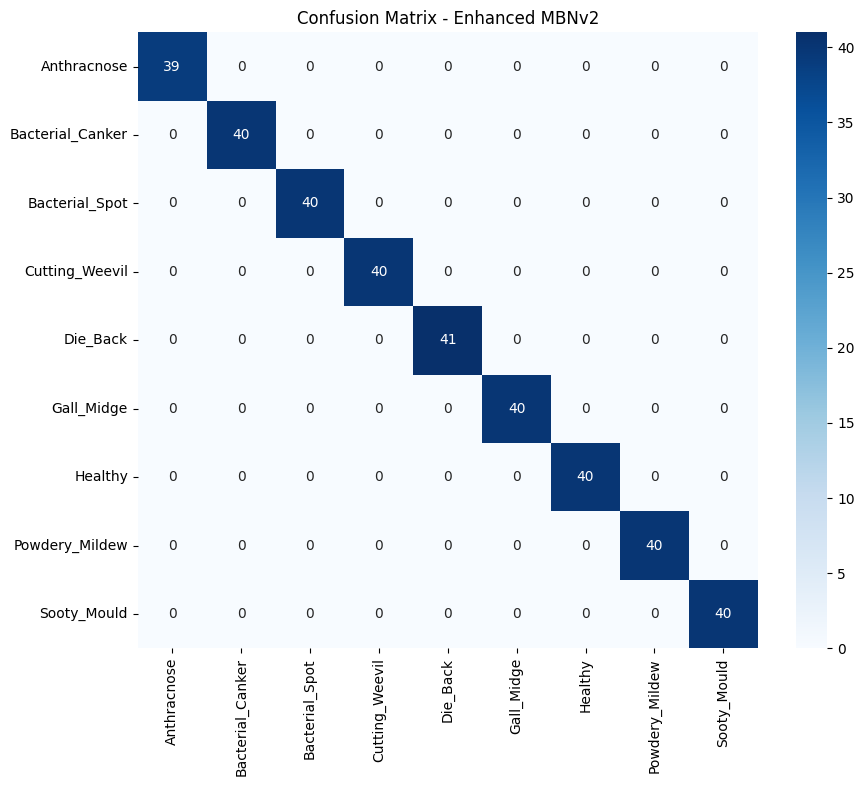

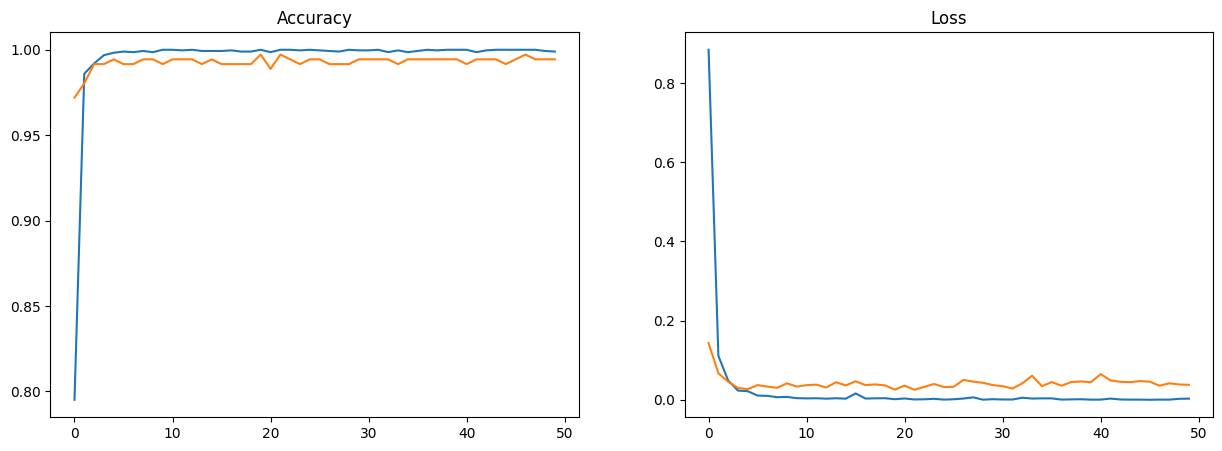

Done! Kết quả tại: d:\HUTECH\AI\DeepLearning\DAHS\MangoLeaf\Result\MBN_Caitien


In [7]:
# Khởi tạo Training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scaler = torch.amp.GradScaler('cuda')
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

# Vòng lặp Train
for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        tr_loss += loss.item(); tr_correct += (outputs.argmax(1) == labels).sum().item()

    # Val Phase
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); v_correct += (outputs.argmax(1) == labels).sum().item()
    
    # Save History
    history['train_acc'].append(tr_correct/len(train_set)); history['val_acc'].append(v_correct/len(val_set))
    history['train_loss'].append(tr_loss/len(train_loader)); history['val_loss'].append(v_loss/len(val_loader))
    
    if (v_correct/len(val_set)) > best_acc:
        best_acc = v_correct/len(val_set)
        torch.save(model.state_dict(), os.path.join(MBN_RES_PATH, 'best_model.pth'))

# --- SAU KHI TRAIN XONG: ĐÁNH GIÁ & LƯU KẾT QUẢ ---
model.load_state_dict(torch.load(os.path.join(MBN_RES_PATH, 'best_model.pth')))
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        y_true.extend(labels.numpy()); y_pred.extend(outputs.argmax(1).cpu().numpy())

# 1. Lưu Report
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
with open(os.path.join(MBN_RES_PATH, 'report.json'), 'w') as f: json.dump(report, f, indent=4)

# 2. Vẽ Matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix - Enhanced MBNv2'); plt.savefig(os.path.join(MBN_RES_PATH, 'matrix.png')); plt.show()

# 3. Vẽ Biểu đồ Acc/Loss
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(history['train_acc'], label='Train'); ax[0].plot(history['val_acc'], label='Val'); ax[0].set_title('Accuracy')
ax[1].plot(history['train_loss'], label='Train'); ax[1].plot(history['val_loss'], label='Val'); ax[1].set_title('Loss')
plt.savefig(os.path.join(MBN_RES_PATH, 'curves.png')); plt.show()

print(f"Done! Kết quả tại: {MBN_RES_PATH}")